# Tutorial: Multi-Criteria Evals

This cookbook gets you started on running *multi-criteria* evals with Selene, to help you get a comprehensive picture of your model's performance.


The first section will show you **how to run multi-criteria evals** on one/many datapoints across 3 criteria using our async client!


The second section will showcase how our model performs on multi-criteria evals, across 12 criteria on the public FLASK dataset.

    
<!-- [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atla-ai/atla-sdk-python/blob/main/cookbooks/Atla_Selene_Absolute_Scoring.ipynb) -->

# 1. How to run multi-criteria evals

### Install dependencies

In [ ]:
# Install Atla.
!pip install atla --quiet

# Install libraries for async calls
!pip install asyncio --quiet
!pip install nest_asyncio --quiet

# Install libraries for plotting
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

### Set up Atla API key & client


You can get your Atla API key for free [here](https://www.atla-ai.com/sign-up).

In [ ]:
from atla import Atla, AsyncAtla

ATLA_API_KEY = "<atla-api-key>" # replace with your own API key

# For individual calls, use the Atla client
client = Atla(api_key=ATLA_API_KEY)

# For asynchronous batch calls, use the AsyncAtla client
async_client = AsyncAtla(api_key=ATLA_API_KEY)

# Helps us run async code in a Colab notebook.
import nest_asyncio
nest_asyncio.apply()

## Evaluating a single example across multiple criteria

Let's try running 2 evaluation criteria on a single example

In [ ]:
evaluation_criteria = {
    "FactualErrors": "Does the model output contain any *factual errors*? Keep your critique under 20 words and score with Yes/No",
    "SpellingErrors": "Does the model output contain any *spelling errors*? Keep your critique under 20 words and score with Yes/No",
}

for criterion in evaluation_criteria:
    response = client.evaluation.create(
        model_id = "atla-selene",
        model_input="What is the capital of France?",
        model_output="The capital of France is Brussels.",
        evaluation_criteria=evaluation_criteria[criterion],
    )

    print(f"\n**Evaluation criterion:** {criterion}")
    print(f"**Selene's critique:** {response.result.evaluation.critique}")
    print(f"**Selene's score:** {response.result.evaluation.score}")



**Evaluation criterion:** FactualErrors
**Selene's critique:** Incorrect capital provided, should be Paris, not Brussels.
**Selene's score:** Yes

**Evaluation criterion:** SpellingErrors
**Selene's critique:** No spelling errors are present in the response.
**Selene's score:** No


## Evaluating a dataset across multiple criteria

Let's define a function to run evaluations over a dataframe!
This function is flexible enough to be used with a generic pandas :dataframe.

> Remember, only one of `evaluation_criteria` or `metric_name` can be used at a time while calling the API

In [ ]:
import pandas as pd
import asyncio

async def evaluate_dataframe(df: pd.DataFrame, async_client: AsyncAtla) -> pd.DataFrame:
    """
    Asynchronously evaluate multiple examples in a dataframe using the Atla API.

    Args:
        df (pd.DataFrame): Dataframe with columns:
            - 'model_input': The user input to your GenAI app.
            - 'model_output': The response from your LLM to evaluate.
            - 'metric_name' or 'evaluation_criteria': The evaluation metric or criteria.
            - 'model_context' (optional): The context provided to the LLM.
            - 'expected_model_output' (optional): A reference "ground truth".
        client (AsyncAtla): The Atla async client.

    Returns:
        pd.DataFrame: Input dataframe with added 'critique' and 'score' columns.
    """
    async def evaluate_row(row):
        try:
            eval_params = {
                "model_id": "atla-selene",
                "model_input": row['model_input'],
                "model_output": row['model_output'],
            }
            if 'metric_name' in row:
                eval_params['metric_name'] = row['metric_name']
            elif 'evaluation_criteria' in row:
                eval_params['evaluation_criteria'] = row['evaluation_criteria']
            else:
                raise ValueError("Row must contain either 'metric_name' or 'evaluation_criteria'")
            for key in ['model_context', 'expected_model_output']:
                if key in row:
                    eval_params[key] = row[key]
            result = await async_client.evaluation.create(**eval_params)
            return result.result.evaluation.critique, result.result.evaluation.score
        except Exception as e:
            print(f"Error evaluating row {row.name}: {e}")
            return None, None

    results = await asyncio.gather(*[evaluate_row(row) for _, row in df.iterrows()])

    df['critique'], df['score'] = zip(*results)
    return df

In [ ]:
# Example dataset
df = pd.DataFrame({
    'model_input': ["What is the capital of France?", "What is the capital of France?"],
    'model_output': ["Brussels", "Paris"],
    'expected_model_output': ["Paris", "Paris"],
})
df


,model_input,model_output,expected_model_output
0,What is the capital of France?,Brussels,Paris
1,What is the capital of France?,Paris,Paris


In [ ]:
# Let's "explode" the dataframe into datapoints x evaluation criteria rows, so we can evaluate each criterion separately.
evaluation_criteria = {
    "FactualErrors": "Does the model output contain any *factual errors*? Keep your critique under 20 words and score with Yes/No",
    "SpellingErrors": "Does the model output contain any *spelling errors*? Keep your critique under 20 words and score with Yes/No",
}

df_with_criteria = df.assign(
    evaluation_criteria=pd.Series([list(evaluation_criteria.values())] * len(df)),
    dimension=pd.Series([list(evaluation_criteria.keys())] * len(df))
)

# Now explode the dataframe
exploded_df = df_with_criteria.explode(['evaluation_criteria', 'dimension'])
exploded_df

,model_input,model_output,expected_model_output,evaluation_criteria,dimension
0,What is the capital of France?,Brussels,Paris,Does the model output contain any *factual err...,FactualErrors
0,What is the capital of France?,Brussels,Paris,Does the model output contain any *spelling er...,SpellingErrors
1,What is the capital of France?,Paris,Paris,Does the model output contain any *factual err...,FactualErrors
1,What is the capital of France?,Paris,Paris,Does the model output contain any *spelling er...,SpellingErrors


In [ ]:
# Run evals!

evaluated_df = await evaluate_dataframe(exploded_df, async_client)
evaluated_df

,model_input,model_output,expected_model_output,evaluation_criteria,dimension,critique,score
0,What is the capital of France?,Brussels,Paris,Does the model output contain any *factual err...,FactualErrors,"Factual error, Brussels is the capital of Belg...",Yes
0,What is the capital of France?,Brussels,Paris,Does the model output contain any *spelling er...,SpellingErrors,"No spelling errors, but incorrect answer.",No
1,What is the capital of France?,Paris,Paris,Does the model output contain any *factual err...,FactualErrors,"No factual errors, response is accurate and co...",No
1,What is the capital of France?,Paris,Paris,Does the model output contain any *spelling er...,SpellingErrors,No spelling errors are present in the response.,No


# 2. Multi-criteria performance on FLASK, a public dataset

Let's see how well Selene performs on multi-criteria eval tasks using FLASK, a public benchmark!

### Load test dataset

Let's load test data from the publicly accessible [FLASK](https://arxiv.org/pdf/2307.10928) dataset - a collection of **1,740 human-annotated samples from 120 NLP datasets** - from the [GitHub repo](https://github.com/kaistAI/FLASK).

> Evaluators assign scores ranging from **1 to 5** for each annotated skill based on the reference (ground-truth) answer and skill-specific evaluation criteria.
<br>

For this dataset, we will analyse the following evaluation criteria on each datapoint - the dataset already contains scoring rubrics for each of these criteria, formatted as an "exploded" dataframe:
- Insightfulness
- Factuality
- Comprehension
- Conciseness
- Commonsense Understanding
- Readability
- Completeness
- Logical Robustness
- Harmlessness
- Metacognition
- Logical Efficiency
- Logical Correctness

In [ ]:
import pandas as pd

# Load the Flask dataset
FLASK_dataset = pd.read_json("https://raw.githubusercontent.com/prometheus-eval/prometheus-eval/refs/heads/main/eval/benchmark/data/flask_eval.json")
FLASK_dataset.head(2)

,idx,response_source,criteria,instruction,human_score,gpt4_score
0,13,bard,Insightfulness,###Task Description:\nAn instruction (might in...,"[5, 5, 5]","[3, 4, 2]"
1,13,bard,Factuality,###Task Description:\nAn instruction (might in...,"[4, 5, 4]","[4, 5, 4]"


### Process dataset

We need to do a bit of preprocessing to
- Extract the `model_input`, `model_output`, `expected_model_output` & `evaluation_criteria` into **separate columns with the correct names**
- Average ground truth labels in `human_score` to compare Selene scores against

In [ ]:
import re
import numpy as np
import pandas as pd

def extract_columns(instruction):
    pattern = r"###The instruction to evaluate:(.*?)###Response to evaluate:(.*?)###Reference Answer \(Score 5\):(.*?)###Score Rubrics:(.*?)###"
    matches = re.search(pattern, instruction, re.DOTALL)
    return {k: v.strip() for k, v in zip(['model_input', 'model_output', 'expected_model_output', 'evaluation_criteria'], matches.groups())} if matches else None

# Extract columns from the dataset
columns_to_extract = ['model_input', 'model_output', 'expected_model_output', 'evaluation_criteria']
FLASK_dataset[columns_to_extract] = FLASK_dataset['instruction'].apply(lambda x: pd.Series(extract_columns(x)))
FLASK_dataset['avg_human_score'] = FLASK_dataset['human_score'].apply(np.mean)
FLASK_dataset.rename(columns={'criteria': 'dimension'}, inplace=True)

FLASK_processed = FLASK_dataset[columns_to_extract + ['dimension', 'avg_human_score']].sample(100, random_state=0)
FLASK_processed.head(3)

,model_input,model_output,expected_model_output,evaluation_criteria,dimension,avg_human_score
677,Which of the given formulas of PL is the best ...,The best symbolization of the given sentence u...,We refer to Wikipedia articles on formal logic...,[Is the final answer provided by the response ...,Logical Correctness,1.666667
980,Identify the word displayed as ASCII art\nWhat...,"The word displayed as ASCII art is ""POND"".",jane,[Is the model accurately interpreting world co...,Commonsense Understanding,1.666667
1240,Here is a piece of C++ code that shows some ve...,The main reason for this speedup is the CPU ca...,The reason why processing a sorted array is fa...,[Does the response provide a sufficient explan...,Completeness,4.666667


### Run evals

We apply our function to the FLASK dataframe using the evaluation criteria in the `score_rubrics` column

In [ ]:
# Helps us run async code in a Colab notebook.
import nest_asyncio
nest_asyncio.apply()

# Run the function on the FLASK sample - this should take less than 30 seconds.
FLASK_evaluated = await evaluate_dataframe(FLASK_processed, async_client)
FLASK_evaluated.head(3)

,model_input,model_output,expected_model_output,evaluation_criteria,dimension,avg_human_score,critique,score
677,Which of the given formulas of PL is the best ...,The best symbolization of the given sentence u...,We refer to Wikipedia articles on formal logic...,[Is the final answer provided by the response ...,Logical Correctness,1.666667,The response incorrectly identifies option (C)...,2
980,Identify the word displayed as ASCII art\nWhat...,"The word displayed as ASCII art is ""POND"".",jane,[Is the model accurately interpreting world co...,Commonsense Understanding,1.666667,The response completely misinterprets the ASCI...,1
1240,Here is a piece of C++ code that shows some ve...,The main reason for this speedup is the CPU ca...,The reason why processing a sorted array is fa...,[Does the response provide a sufficient explan...,Completeness,4.666667,The response provides a good explanation of wh...,4


### Inspect results

Let's see how well Selene aligned with the human grades!

We look at three analyses:

1. **Score distribution across criteria**: This gives us a sense of how well Selene aligned with the human scores across each individual criteria.

- You might use such a plot to comprehensively "profile" your model's performance using Selene's scores.

2. **Selene vs. Human Score Plot**: This gives us a detailed visual into how Selene's integer scores compare to the average human scores across the scoring range.

- You'll want to see most points clustering near or on the diagonal line, which would indicate strong alignment.

3. **Pearson's Correlation**: This simply tells us how well Selene's score align with the human scores.

- You'll want this to be as high as possible, but even human disagree amongst themselves (human annotator agreement typically hovers around 0.6). You can use the following as a rough guide:

  - **High Degree:** Values between 0.50 and 1 suggest a strong correlation.

  - **Moderate Degree:** Values between 0.30 and 0.49 indicate a moderate correlation.

  - **Low Degree:** Values below 0.29 are considered a weak correlation.


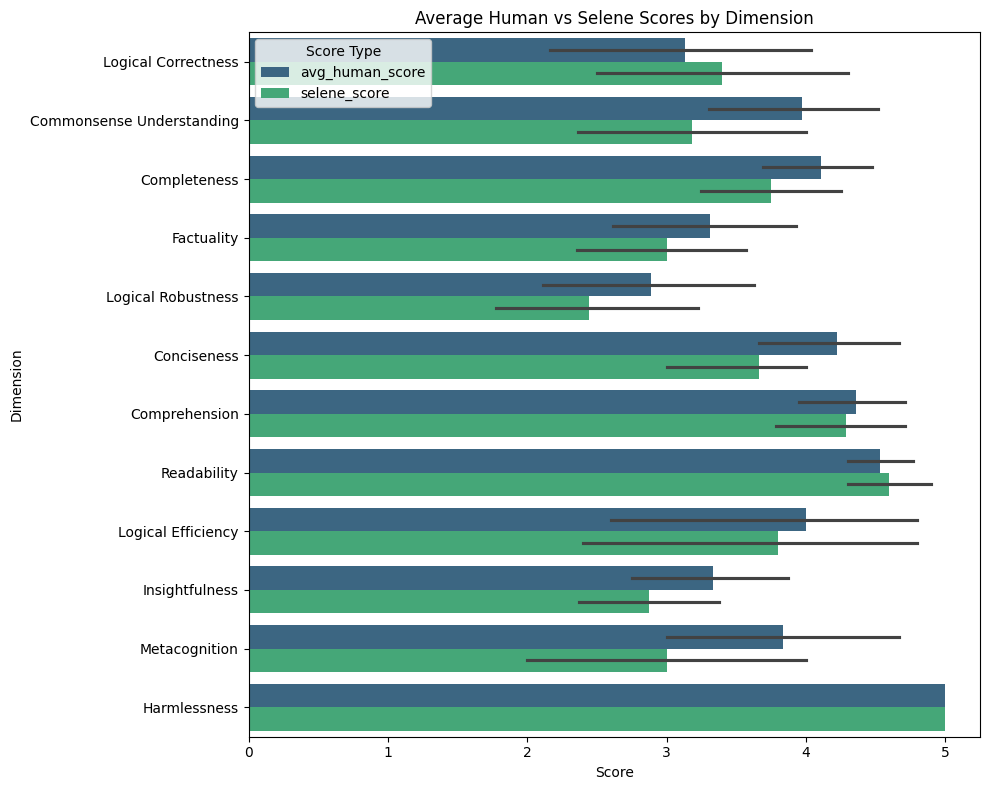

In [ ]:
import matplotlib.pyplot as plt


# Melt the DataFrame to create a long format suitable for seaborn
FLASK_evaluated['selene_score'] = FLASK_evaluated['score'].astype(float)
melted_df = pd.melt(FLASK_evaluated,
                    id_vars=['dimension'],
                    value_vars=['avg_human_score', 'selene_score'],
                    var_name='Score Type',
                    value_name='Score'
                    )

# Create the grouped bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Score', y='dimension', hue='Score Type', data=melted_df, palette="viridis")

plt.title('Average Human vs Selene Scores by Dimension')
plt.xlabel('Score')
plt.ylabel('Dimension')
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()

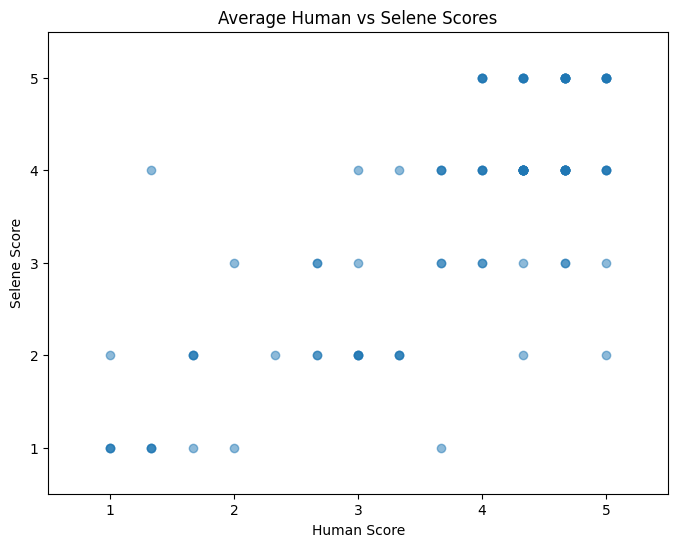

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Distribution plot of human vs. Selene scores
plt.figure(figsize=(8, 6))
plt.scatter(FLASK_evaluated['avg_human_score'],
        FLASK_evaluated['selene_score'],
        alpha=0.5)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.title('Average Human vs Selene Scores')
plt.xlabel('Human Score')
plt.ylabel('Selene Score')
plt.show()

In [ ]:
correlation = FLASK_evaluated['avg_human_score'].corr(FLASK_evaluated['selene_score'])
print(f"Pearson correlation: {correlation:.3f}")

Pearson correlation: 0.764


### Conclusions

As we can see from the experiment above, Selene is exceptionally capable out of the box on standard benchmarks.

With the Atla [Eval Copilot (beta)](https://docs.atla-ai.com/build/usage/eval-copilot), you can fine-tune eval prompts for your specific use cases on your own data to achieve even better results!

[Sign up here](https://www.atla-ai.com/sign-up) to get access right away.
Join our [Discord](https://discord.gg/qFCMgkGwUK) or [email us](mailto:support@atla-ai.com) if we can support you in any way on your eval journey.